##### Read 2019 Sales Data from Parquet Directory

In [165]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_list, count, date_format, expr, round, size, sum
from pyspark.sql.types import FloatType, IntegerType
import seaborn as sns

In [124]:
spark = SparkSession.builder.appName("Challenge_3").getOrCreate()

In [125]:
type(spark)

pyspark.sql.session.SparkSession

In [126]:
file_path = "./output/sales/"

sales_data_df = spark.read.parquet(file_path)

sales_data_df.show(10, truncate=False)

+-------+--------------------------+--------+------+-------------------+--------------------------------------+-------------+-----+----------+-----+
|OrderID|Product                   |Quantity|Price |OrderDate          |StoreAddress                          |City         |State|ReportYear|Month|
+-------+--------------------------+--------+------+-------------------+--------------------------------------+-------------+-----+----------+-----+
|296174 |27in FHD Monitor          |1       |149.99|2019-12-29 09:38:00|982 Cherry St, Portland, OR 97035     |Portland     |OR   |2019      |12   |
|296176 |Wired Headphones          |1       |11.99 |2019-12-11 17:56:00|893 Cedar St, San Francisco, CA 94016 |San Francisco|CA   |2019      |12   |
|296475 |27in 4K Gaming Monitor    |1       |389.99|2019-12-27 12:57:00|309 South St, Los Angeles, CA 90001   |Los Angeles  |CA   |2019      |12   |
|297038 |Apple Airpods Headphones  |1       |150.0 |2019-12-28 20:47:00|778 Park St, New York City, NY 100

In [127]:
sales_data_df.count()

185686

##### Question 1: What was the best month in terms of sales?

In [128]:
sales_data_df.withColumn("TotalSales", expr("Price * Quantity"))\
            .groupBy("Month")\
            .agg(sum("TotalSales").alias("GrandTotalSales"))\
            .show(5, truncate=False)

+-----+------------------+
|Month|GrandTotalSales   |
+-----+------------------+
|12   |4608295.6761312485|
|1    |1821413.1513473988|
|6    |2576280.137305975 |
|3    |2804973.335673094 |
|5    |3150616.21493268  |
+-----+------------------+
only showing top 5 rows



In [129]:
sales_data_df.printSchema()

root
 |-- OrderID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- OrderDate: string (nullable = true)
 |-- StoreAddress: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ReportYear: integer (nullable = true)
 |-- Month: integer (nullable = true)



In [130]:
sales_data_df.groupBy("Month").agg(count("Month")).show(truncate=False)

+-----+------------+
|Month|count(Month)|
+-----+------------+
|12   |24944       |
|1    |9699        |
|6    |13535       |
|3    |15128       |
|5    |16552       |
|9    |11603       |
|4    |18257       |
|8    |11943       |
|7    |14275       |
|10   |20249       |
|11   |17544       |
|2    |11957       |
+-----+------------+



In [131]:
sales_q1_df = sales_data_df.select(
    col("OrderID"),
    col("Month"),
    col("Price"),
    col("Quantity"),
    expr("Price * Quantity").alias("Sales"))

In [132]:
sales_q1_df.show(10, truncate=False)

+-------+-----+------+--------+------+
|OrderID|Month|Price |Quantity|Sales |
+-------+-----+------+--------+------+
|296174 |12   |149.99|1       |149.99|
|296176 |12   |11.99 |1       |11.99 |
|296475 |12   |389.99|1       |389.99|
|297038 |12   |150.0 |1       |150.0 |
|297142 |12   |700.0 |1       |700.0 |
|297342 |12   |11.95 |1       |11.95 |
|297695 |12   |99.99 |1       |99.99 |
|297902 |12   |11.99 |1       |11.99 |
|297992 |12   |600.0 |1       |600.0 |
|298194 |12   |14.95 |1       |14.95 |
+-------+-----+------+--------+------+
only showing top 10 rows



In [133]:
sales_q1_df = sales_q1_df.groupBy("Month")\
                        .agg(round(sum("Sales"), 2).alias("TotalSales"))\
                        .orderBy("TotalSales", ascending=False)

In [134]:
sales_q1_df.show(10, truncate=False)

+-----+----------+
|Month|TotalSales|
+-----+----------+
|12   |4608295.68|
|10   |3734777.84|
|4    |3389217.96|
|11   |3197875.03|
|5    |3150616.21|
|3    |2804973.34|
|7    |2646461.31|
|6    |2576280.14|
|8    |2241083.36|
|2    |2200078.07|
+-----+----------+
only showing top 10 rows



In [135]:
pd_sales_q1 = sales_q1_df.orderBy("Month", ascending=False).toPandas()

In [136]:
pd_sales_q1

,Month,TotalSales
0,12,4608295.68
1,11,3197875.03
2,10,3734777.84
3,9,2094465.68
4,8,2241083.36
5,7,2646461.31
6,6,2576280.14
7,5,3150616.21
8,4,3389217.96
9,3,2804973.34


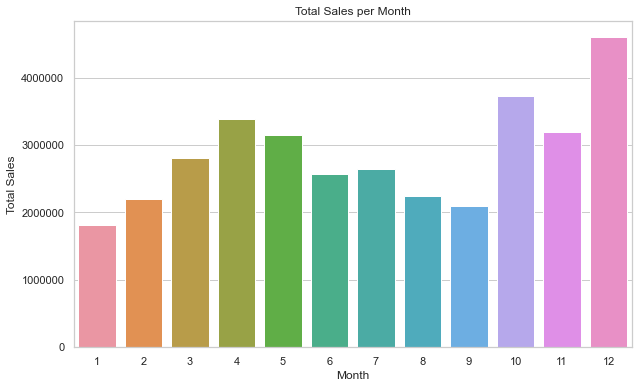

In [137]:
plt.figure(figsize=(10, 6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="whitegrid")
sns.barplot(x="Month", y="TotalSales", data=pd_sales_q1).set_title("Total Sales per Month")
plt.ylabel("Total Sales")
plt.show()

- December is best month in terms of sales.

##### What City Actually Sold the Most Products?

In [138]:
sales_data_df.groupBy("City")\
            .agg(sum("Quantity").alias("SumQuantity"))\
            .orderBy("SumQuantity", ascending=False)\
            .show(5, truncate=False)

+-------------+-----------+
|City         |SumQuantity|
+-------------+-----------+
|San Francisco|50169      |
|Los Angeles  |33247      |
|New York City|27903      |
|Boston       |22494      |
|Dallas       |16707      |
+-------------+-----------+
only showing top 5 rows



In [139]:
sales_data_df.select("OrderID", "Quantity", "City").show(truncate=False)

+-------+--------+-------------+
|OrderID|Quantity|City         |
+-------+--------+-------------+
|296174 |1       |Portland     |
|296176 |1       |San Francisco|
|296475 |1       |Los Angeles  |
|297038 |1       |New York City|
|297142 |1       |Dallas       |
|297342 |1       |San Francisco|
|297695 |1       |Atlanta      |
|297902 |1       |Austin       |
|297992 |1       |Atlanta      |
|298194 |1       |San Francisco|
|298348 |1       |Los Angeles  |
|298394 |1       |Seattle      |
|298541 |1       |Los Angeles  |
|298552 |1       |Los Angeles  |
|298644 |1       |San Francisco|
|298695 |3       |Atlanta      |
|299271 |1       |Atlanta      |
|299798 |1       |New York City|
|299965 |1       |Los Angeles  |
|299981 |1       |Portland     |
+-------+--------+-------------+
only showing top 20 rows



In [140]:
sales_q2_df = sales_data_df.groupBy("City")\
                        .agg(sum("Quantity").alias("TotalProducts"))\
                        .orderBy("TotalProducts", ascending=False)

In [141]:
sales_q2_df.show(10, truncate=False)

+-------------+-------------+
|City         |TotalProducts|
+-------------+-------------+
|San Francisco|50169        |
|Los Angeles  |33247        |
|New York City|27903        |
|Boston       |22494        |
|Dallas       |16707        |
|Atlanta      |16584        |
|Seattle      |16534        |
|Portland     |14037        |
|Austin       |11137        |
+-------------+-------------+



- San Francisco sold the most products

In [147]:
pd_sales_q2 = sales_q2_df.toPandas()

In [148]:
pd_sales_q2

,City,TotalProducts
0,San Francisco,50169
1,Los Angeles,33247
2,New York City,27903
3,Boston,22494
4,Dallas,16707
5,Atlanta,16584
6,Seattle,16534
7,Portland,14037
8,Austin,11137


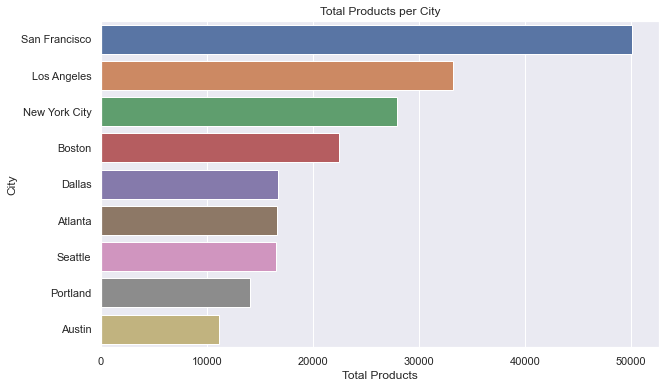

In [151]:
plt.figure(figsize=(10, 6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="darkgrid")
sns.barplot(x="TotalProducts", y="City", data=pd_sales_q2).set_title("Total Products per City")
plt.xlabel("Total Products")
plt.show()

##### What time should we display advertisements to maximize the likelihood of customers buying products?

In [142]:
updated_sales_data_df = sales_data_df.withColumn("hour", date_format("OrderDate", "HH"))\
                                    .withColumn("TotalSales", expr("Price * Quantity").cast(FloatType()))

updated_sales_data_df.groupBy(col("hour").cast(IntegerType()))\
                    .agg(sum(col("TotalSales")))\
                    .show(5, truncate=False)

+-----------------+------------------+
|CAST(hour AS INT)|sum(TotalSales)   |
+-----------------+------------------+
|12               |2314359.8384149075|
|22               |1606243.8415923119|
|1                |460563.8978149891 |
|13               |2152369.9689331055|
|16               |1902523.1909103394|
+-----------------+------------------+
only showing top 5 rows



In [153]:
sales_data_df.show(10, truncate=False)

+-------+--------------------------+--------+------+-------------------+--------------------------------------+-------------+-----+----------+-----+
|OrderID|Product                   |Quantity|Price |OrderDate          |StoreAddress                          |City         |State|ReportYear|Month|
+-------+--------------------------+--------+------+-------------------+--------------------------------------+-------------+-----+----------+-----+
|296174 |27in FHD Monitor          |1       |149.99|2019-12-29 09:38:00|982 Cherry St, Portland, OR 97035     |Portland     |OR   |2019      |12   |
|296176 |Wired Headphones          |1       |11.99 |2019-12-11 17:56:00|893 Cedar St, San Francisco, CA 94016 |San Francisco|CA   |2019      |12   |
|296475 |27in 4K Gaming Monitor    |1       |389.99|2019-12-27 12:57:00|309 South St, Los Angeles, CA 90001   |Los Angeles  |CA   |2019      |12   |
|297038 |Apple Airpods Headphones  |1       |150.0 |2019-12-28 20:47:00|778 Park St, New York City, NY 100

In [154]:
sales_data_df.groupBy("OrderID").agg(count("OrderID").alias("Count"))\
            .where(col("Count") > 1).show(10, truncate=False)

+-------+-----+
|OrderID|Count|
+-------+-----+
|300601 |2    |
|304276 |2    |
|310188 |2    |
|276515 |2    |
|188122 |2    |
|269251 |2    |
|265863 |2    |
|284489 |2    |
|261569 |2    |
|277349 |2    |
+-------+-----+
only showing top 10 rows



In [155]:
sales_data_df.filter(col("OrderID") == 304276).show(truncate=False)

+-------+---------------+--------+------+-------------------+-----------------------------------+-------------+-----+----------+-----+
|OrderID|Product        |Quantity|Price |OrderDate          |StoreAddress                       |City         |State|ReportYear|Month|
+-------+---------------+--------+------+-------------------+-----------------------------------+-------------+-----+----------+-----+
|304276 |ThinkPad Laptop|1       |999.99|2019-12-15 06:07:00|358 5th St, New York City, NY 10001|New York City|NY   |2019      |12   |
|304276 |iPhone         |1       |700.0 |2019-12-15 06:07:00|358 5th St, New York City, NY 10001|New York City|NY   |2019      |12   |
+-------+---------------+--------+------+-------------------+-----------------------------------+-------------+-----+----------+-----+



In [158]:
sales_q3_df = sales_data_df.select(
    "OrderID", date_format("OrderDate", "HH").cast(IntegerType()).alias("Hour")
).distinct()\
 .groupBy("Hour")\
 .agg(count("Hour").alias("TotalOrders"))\
 .orderBy("TotalOrders", ascending=False)

In [159]:
sales_q3_df.show(truncate=False)

+----+-----------+
|Hour|TotalOrders|
+----+-----------+
|19  |12377      |
|12  |12082      |
|11  |11882      |
|20  |11763      |
|18  |11761      |
|13  |11682      |
|14  |10522      |
|21  |10499      |
|10  |10492      |
|17  |10476      |
|16  |9960       |
|15  |9761       |
|22  |8453       |
|9   |8404       |
|8   |6036       |
|23  |5990       |
|7   |3836       |
|0   |3758       |
|6   |2375       |
|1   |2255       |
+----+-----------+
only showing top 20 rows



In [160]:
pd_sales_q3 = sales_q3_df.orderBy("Hour").toPandas()

In [162]:
pd_sales_q3

,Hour,TotalOrders
0,0,3758
1,1,2255
2,2,1193
3,3,807
4,4,814
5,5,1259
6,6,2375
7,7,3836
8,8,6036
9,9,8404


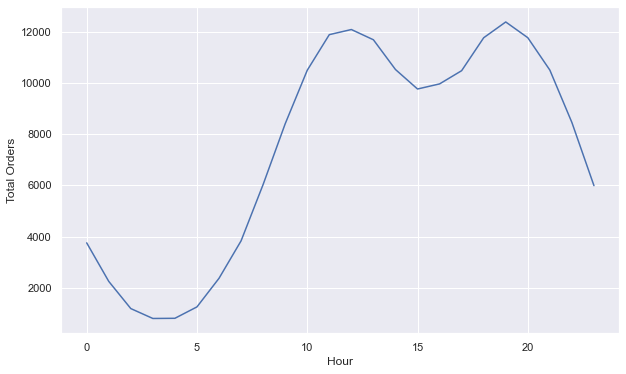

In [164]:
plt.figure(figsize=(10, 6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="whitegrid")
sns.lineplot(x="Hour", y="TotalOrders", data=pd_sales_q3)
plt.ylabel("Total Orders")
plt.show()

##### What products are often sold together in the state "NY"?

In [143]:
sales_data_df.printSchema()

root
 |-- OrderID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- OrderDate: string (nullable = true)
 |-- StoreAddress: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ReportYear: integer (nullable = true)
 |-- Month: integer (nullable = true)



In [144]:
sales_data_df.select("OrderID").count()

185686

In [145]:
sales_data_df.select("OrderID").distinct().count()

178437

In [166]:
sales_q4_df = sales_data_df.where(col("State") == "NY")\
                        .orderBy("OrderID", "Product")\
                        .groupBy("OrderID", "State")\
                        .agg(collect_list("Product").alias("ProductList"))

In [167]:
sales_q4_df.show(10, truncate=False)

+-------+-----+------------------------------------------------+
|OrderID|State|ProductList                                     |
+-------+-----+------------------------------------------------+
|141851 |NY   |[27in FHD Monitor]                              |
|142149 |NY   |[AA Batteries (4-pack)]                         |
|142787 |NY   |[Lightning Charging Cable]                      |
|143020 |NY   |[ThinkPad Laptop]                               |
|143862 |NY   |[Apple Airpods Headphones]                      |
|144151 |NY   |[LG Dryer]                                      |
|144851 |NY   |[Apple Airpods Headphones, USB-C Charging Cable]|
|146589 |NY   |[Wired Headphones]                              |
|147784 |NY   |[AAA Batteries (4-pack)]                        |
|148099 |NY   |[27in 4K Gaming Monitor]                        |
+-------+-----+------------------------------------------------+
only showing top 10 rows



In [169]:
sales_q4_df = sales_q4_df.withColumn("ProductListSize", size("ProductList"))
sales_q4_df.filter(col("ProductListSize") > 1).orderBy("ProductList").show(10, truncate=False)

+-------+-----+----------------------------------------+---------------+
|OrderID|State|ProductList                             |ProductListSize|
+-------+-----+----------------------------------------+---------------+
|253929 |NY   |[20in Monitor, 27in 4K Gaming Monitor]  |2              |
|248053 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|197004 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|266247 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|158102 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|245465 |NY   |[20in Monitor, AAA Batteries (4-pack)]  |2              |
|176251 |NY   |[20in Monitor, AAA Batteries (4-pack)]  |2              |
|194762 |NY   |[20in Monitor, AAA Batteries (4-pack)]  |2              |
|204645 |NY   |[20in Monitor, Apple Airpods Headphones]|2              |
|234956 |NY   |[20in Monitor, Apple Airpods Headphones]|2              |
+-------+-----+------------------------------------

In [171]:
sales_q4_df.filter(col("ProductListSize") > 1)\
        .groupBy("ProductList")\
        .agg(count("ProductList").alias("Appearances"))\
        .orderBy("Appearances", ascending=False)\
        .show(10, truncate=False)

+-------------------------------------------------+-----------+
|ProductList                                      |Appearances|
+-------------------------------------------------+-----------+
|[Google Phone, USB-C Charging Cable]             |127        |
|[Lightning Charging Cable, iPhone]               |127        |
|[Google Phone, Wired Headphones]                 |53         |
|[USB-C Charging Cable, Vareebadd Phone]          |50         |
|[Wired Headphones, iPhone]                       |46         |
|[Apple Airpods Headphones, iPhone]               |45         |
|[Bose SoundSport Headphones, Google Phone]       |24         |
|[Apple Airpods Headphones, Wired Headphones]     |19         |
|[Vareebadd Phone, Wired Headphones]              |17         |
|[AA Batteries (4-pack), Lightning Charging Cable]|16         |
+-------------------------------------------------+-----------+
only showing top 10 rows

